### Set up some python packages for analysis 

In [4]:
import os
import math
import pandas as pd
import numpy as np
from pybedtools import BedTool
from scipy import stats
import scikit_posthocs as sp
import pyupset as pyu
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from IPython.display import display, Image
from sklearn import manifold
from sklearn.metrics.pairwise import pairwise_distances

# Gubbins analysis goals
1. Hotspots within clusters
2. Differences in rates between clusters
3. Factors causing hotspots (genes, DNA uptake sequences, etc)?


In [5]:
#Read in gubbins results files
gubbins_gff_file_paths = ["./recombination_data/gubbins_recombination_gffs/" + x for x in os.listdir("./recombination_data/gubbins_recombination_gffs/")]
gubbins_csv_file_paths = ["./recombination_data/gubbins_perbranch_stats/" + x for x in os.listdir("./recombination_data/gubbins_perbranch_stats/")]

In [3]:
#Hotspot plotting pipeline

def get_gubbins_cords_and_genomeLegnth(filename): 
    with open(filename, 'r') as temp:
        relevant = temp.readlines()[1] 
        if "##sequence-region" in relevant: 
            genomesize = int(relevant.split()[-1]) 
        else: 
            raise ValueError("GFF seems to be missing genomesize in header") 
    recombinations = BedTool(filename) 
    coords = [] 
    for feature in recombinations: 
        start = int(feature[3]) 
        stop = int(feature[4]) 
        coords.append((start,stop)) 
        output = {"genomesize":genomesize, "coords":coords} 
    return output

def get_recombination_lengths(coordinate_list): 
    sizes = [] 
    for coords in coordinate_list: 
        size = coords[1]-coords[0] 
        if size < 1: 
            raise ValueError("Recombination is of length < 1, check your input!") 
        sizes.append(size) 
    return sizes

def count_window_recombinations(windowrange, coordinatelist): 
    windowcount = 0 
    for recombination in coordinatelist: 
        overlap = min(windowrange[1], recombination[1]) - max(windowrange[0], recombination[0]) 
        if overlap >= 0:
            windowcount += 1 
    return windowcount

def get_discrete_windowcords(genomelength, windowsize): 
    genomeindicies = list(range(genomelength))
    windowsize = 1000 #Hardcoded for now, need to estimate somehow in the future
    windowpairs = [(x, x+windowsize) for x in range(0, genomelength, windowsize)]
    return windowpairs

def get_sliding_windowcords(genomelength, windowsize): 
    genomeindicies = list(range(genomelength))
    windowsize = 1000 #Hardcoded for now, need to estimate somehow in the future
    windowpairs = [(x, x+windowsize) for x in genomeindicies]
    return windowpairs

def get_windows_to_plot(gubbins_file, window_size):
    coordinates = get_gubbins_cords_and_genomeLegnth(gubbins_file)
    windows = get_discrete_windowcords(coordinates["genomesize"], window_size) 
    recombinations = [] 
    for window in windows: 
        recombinations.append(float(count_window_recombinations(window, coordinates["coords"])))
    return recombinations

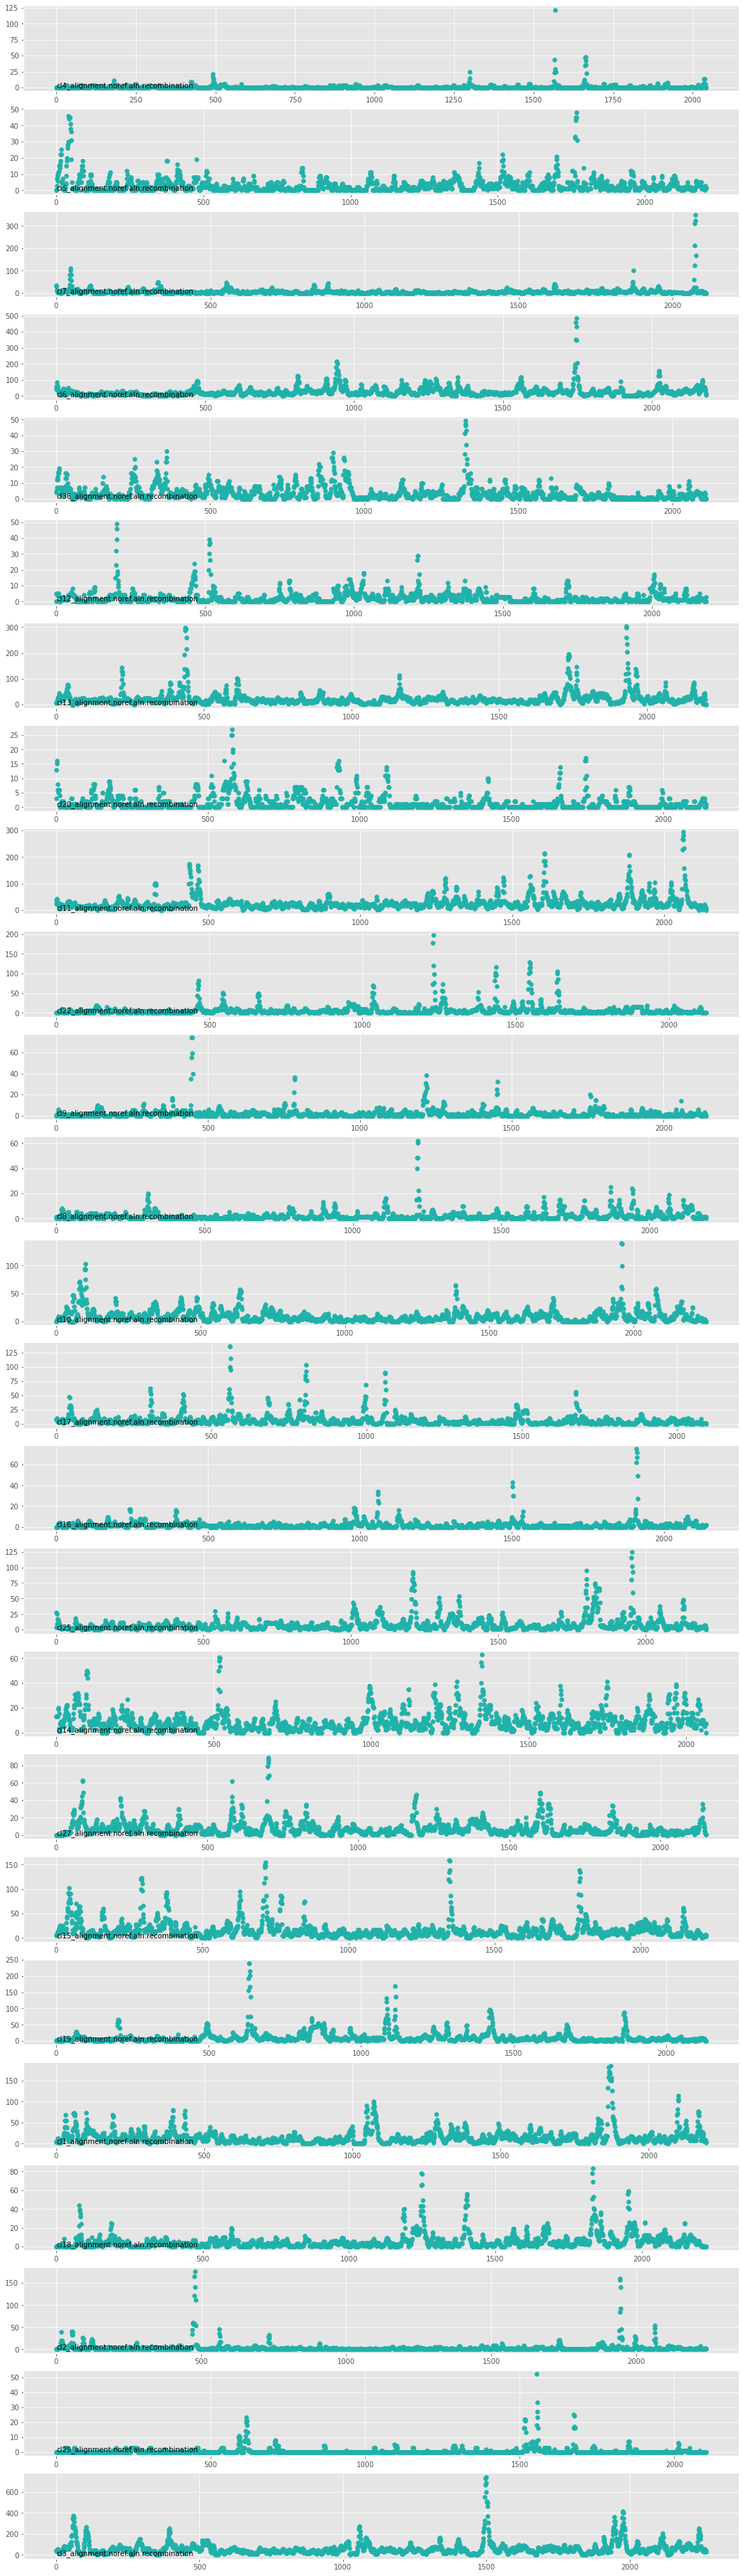

In [4]:
gubbins_manhattan_points = {}
for filepath in gubbins_gff_file_paths:
    name = "_".join(filepath.split("/")[-1].split("_")[:2])
    gubbins_manhattan_points[name] = get_windows_to_plot(filepath, 1000)

clusters = list(gubbins_manhattan_points.keys())
fig=plt.figure(figsize=(18,66))
for index in range(len(clusters)):
    axis = fig.add_subplot(len(clusters),1,index+1)
    axis.scatter(range(len(gubbins_manhattan_points[clusters[index]])), gubbins_manhattan_points[clusters[index]], color="lightseagreen")
    axis.text(0.5, 0.5, clusters[index])

In [5]:
sig_windows = {}
for key in gubbins_manhattan_points:
    sig_windows[key] = [i for i, x in enumerate(gubbins_manhattan_points[key]) if x > np.percentile(gubbins_manhattan_points[key], 99)]

In [279]:
max(gubbins_manhattan_points["cl25_alignment.noref.aln.recombination"])

125.0

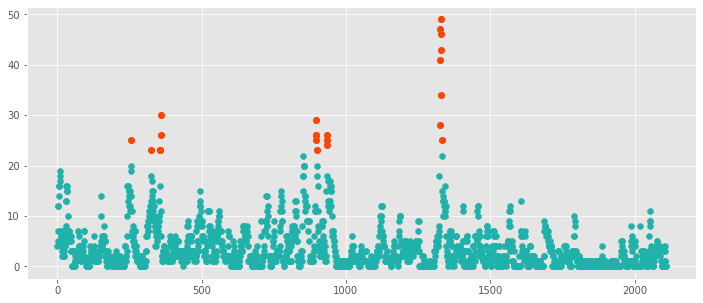

In [38]:
#remake these plots one at a time 
focal_cluster = 'cl36_alignment.noref.aln.recombination'
fig=plt.figure(figsize=(12,5))
plt.scatter(range(len(gubbins_manhattan_points[focal_cluster])), gubbins_manhattan_points[focal_cluster], color="lightseagreen")
for window in sig_windows[focal_cluster]:
    plt.plot(window, gubbins_manhattan_points[focal_cluster][window], 'ro',color="orangered")

In [496]:
#get the average length of recombination for each cluster
lengths = {}
for filename in gubbins_gff_file_paths:
    name = "Cluster "+filename.split("/")[-1].split("_")[0].lstrip("cl")
    parsed = get_gubbins_cords_and_genomeLegnth(filename)
    cluster_lengths = [x[1]-x[0] for x in parsed["coords"]]
    lengths[name] = cluster_lengths

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25]),
 [Text(1, 0, 'Cluster 4'),
  Text(2, 0, 'Cluster 5'),
  Text(3, 0, 'Cluster 7'),
  Text(4, 0, 'Cluster 6'),
  Text(5, 0, 'Cluster 36'),
  Text(6, 0, 'Cluster 12'),
  Text(7, 0, 'Cluster 13'),
  Text(8, 0, 'Cluster 20'),
  Text(9, 0, 'Cluster 11'),
  Text(10, 0, 'Cluster 22'),
  Text(11, 0, 'Cluster 9'),
  Text(12, 0, 'Cluster 8'),
  Text(13, 0, 'Cluster 10'),
  Text(14, 0, 'Cluster 17'),
  Text(15, 0, 'Cluster 16'),
  Text(16, 0, 'Cluster 25'),
  Text(17, 0, 'Cluster 14'),
  Text(18, 0, 'Cluster 27'),
  Text(19, 0, 'Cluster 15'),
  Text(20, 0, 'Cluster 19'),
  Text(21, 0, 'Cluster 1'),
  Text(22, 0, 'Cluster 18'),
  Text(23, 0, 'Cluster 2'),
  Text(24, 0, 'Cluster 29'),
  Text(25, 0, 'Cluster 3')])

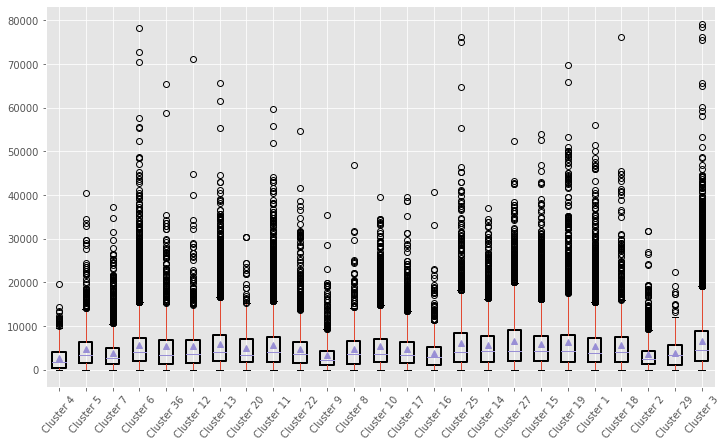

In [498]:
length_boxplot_data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in lengths.items() ]))
boxprops = dict(linestyle='-', linewidth=2, color='k')
fig, ax = plt.subplots(figsize=(12, 7))
ax = length_boxplot_data.boxplot(return_type='axes', showmeans=True, boxprops=boxprops)
#Add upper significance labels
#pos = np.arange(boxplot_data.shape[1]) + 1
#upper_labels = ["2,3,4,6,7,9", "1,4,5,7,8,9","1,4,5,7,8,9","1,2,3,5,6,9","2,3,4,6,9","1,4,5,7,9","1,2,3,6,9","2,3,9","1,2,3,4,5,6,7,8"]
#weights = ['bold', 'semibold']
#for tick, label in zip(range(len(boxplot_data)), ax.get_xticklabels()):
#    k = tick % 2
#    ax.text(pos[tick], .97, upper_labels[tick],
#             transform=ax.get_xaxis_transform(),
#             horizontalalignment='center', size='x-small',
#             weight=weights[k])
#ax.set_ylabel(r'$\rho / \theta$')
plt.xticks(rotation=50)

In [499]:
# Are recombination lengths significantly different?
cl_lengths_test, cl_lengths_p = stats.kruskal(*list(lengths.values()))


In [505]:
column_1 = []
column_2 = []
for cluster in lengths:
    for length in lengths[cluster]:
        column_1.append(length)
        column_2.append(cluster)
dfdict = {"lengths":column_1, "cluster": column_2}
lengths_df = pd.DataFrame(data=dfdict)

            Cluster 1  Cluster 10  Cluster 11  Cluster 12  Cluster 13  \
Cluster 1        -1.0         0.0         0.0         0.0         2.0   
Cluster 10        0.0        -1.0         0.0         0.0         1.0   
Cluster 11        0.0         0.0        -1.0         0.0         0.0   
Cluster 12        0.0         0.0         0.0        -1.0         2.0   
Cluster 13        2.0         1.0         0.0         2.0        -1.0   
Cluster 14        0.0         3.0         0.0         3.0         0.0   
Cluster 15        1.0         1.0         0.0         1.0         0.0   
Cluster 16        1.0         1.0         1.0         1.0         1.0   
Cluster 17        1.0         0.0         1.0         0.0         1.0   
Cluster 18        0.0         0.0         0.0         0.0         0.0   
Cluster 19        0.0         0.0         0.0         0.0         0.0   
Cluster 2         1.0         1.0         1.0         1.0         1.0   
Cluster 20        0.0         0.0         0.0      

(<AxesSubplot:>, <matplotlib.colorbar.ColorbarBase at 0x127eb5400>)

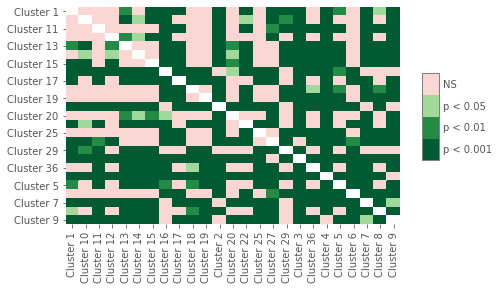

In [507]:
sp.sign_plot(sp.posthoc_dunn(lengths_df, val_col='lengths', group_col='cluster', p_adjust = 'holm'))

In [284]:
#Get the number of zero recombination windows
print(len(gubbins_manhattan_points['cl36_alignment.noref.aln.recombination']))
len([x for x in gubbins_manhattan_points['cl36_alignment.noref.aln.recombination'] if x == 0])

2110


432

In [285]:
#percentage
len([x for x in gubbins_manhattan_points['cl36_alignment.noref.aln.recombination'] if x == 0])/float(len(gubbins_manhattan_points['cl29_alignment.noref.aln.recombination']))

0.20532319391634982

In [108]:
sig_windows.keys()

dict_keys(['cl4_alignment.noref.aln.recombination', 'cl5_alignment.noref.aln.recombination', 'cl7_alignment.noref.aln.recombination', 'cl6_alignment.noref.aln.recombination', 'cl36_alignment.noref.aln.recombination', 'cl12_alignment.noref.aln.recombination', 'cl13_alignment.noref.aln.recombination', 'cl20_alignment.noref.aln.recombination', 'cl11_alignment.noref.aln.recombination', 'cl22_alignment.noref.aln.recombination', 'cl9_alignment.noref.aln.recombination', 'cl8_alignment.noref.aln.recombination', 'cl10_alignment.noref.aln.recombination', 'cl17_alignment.noref.aln.recombination', 'cl16_alignment.noref.aln.recombination', 'cl25_alignment.noref.aln.recombination', 'cl14_alignment.noref.aln.recombination', 'cl27_alignment.noref.aln.recombination', 'cl15_alignment.noref.aln.recombination', 'cl19_alignment.noref.aln.recombination', 'cl1_alignment.noref.aln.recombination', 'cl18_alignment.noref.aln.recombination', 'cl2_alignment.noref.aln.recombination', 'cl29_alignment.noref.aln.recom

In [250]:
cluster_references = {"cl1_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_1_reference.gff",
                      "cl2_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_2_reference.gff",
                      "cl3_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_3_reference.gff",
                      "cl4_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_4_reference_joined.gff",
                      "cl5_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_5_reference.gff",
                      "cl6_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_6_reference.gff",
                      "cl7_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_7_reference_joined.gff",
                      "cl8_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_8_reference.gff",
                      "cl9_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_9_reference_joined.gff",
                      "cl10_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_10_reference.gff",
                      "cl11_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_11_reference_joined.gff",
                      "cl12_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_12_reference_joined.gff",
                      "cl13_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_13_reference_joined.gff",
                      "cl14_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_14_reference.gff",
                      "cl15_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_15_reference.gff",
                      "cl16_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_16_reference_joined.gff",
                      "cl17_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_17_reference_joined.gff",
                      "cl18_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_18_reference_joined.gff",
                      "cl19_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_19_reference_joined.gff",
                      "cl20_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_20_reference_joined.gff",
                      "cl22_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_22_reference_joined.gff",
                      "cl25_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_25_reference_joined.gff",
                      "cl27_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_27_reference_joined.gff",
                      "cl29_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_29_reference_joined.gff",
                      "cl36_alignment.noref.aln.recombination":"./recombination_data/reference_annotations/cluster_36_reference_joined.gff"
                     }

In [5]:
def get_gene_cords(filename):
    with open(filename, 'r') as handle:
        lines = handle.read().splitlines()
        stoppos = lines.index("##FASTA")
    genes = []
    for line in lines[:stoppos]:
        if line[:2] == "##":
            continue
        else:
            genes.append(line.split("\t"))
    positions = []
    products = []
    names = []
    ids = []
    for feature in genes:
        start = int(feature[3])
        stop = int(feature[4])
        positions.append((start,stop))
        extra_data = feature[8].split(";")
        geneid = extra_data[0]
        ids.append(geneid)
        product = "No Product in reference"
        name = "No gene name"
        for thing in extra_data:
            if "product=" in thing:
                product = thing.split("=")[1].strip('"')
                products.append(product)
            if "gene=" in thing:
                name = thing.split("=")[1].strip()
                names.append(name)
        if name == "No gene name":
            names.append(name)
        if product == "No Product in reference":
            products.append(product)
    output = {"positions":positions, "products":products, "names": names, "ids":ids}
    return output

def get_interval_genes(windowint, coordinatelist):
    window_genes_indicies = []
    scaled_windowint = windowint*1000
    windowrange = (scaled_windowint, scaled_windowint+1000)
    for index in range(len(coordinatelist)):
        overlap = min(windowrange[1], coordinatelist[index][1]) - max(windowrange[0], coordinatelist[index][0])
        if overlap >= 0:
            window_genes_indicies.append(index)
    return window_genes_indicies

In [251]:
cluster_gene_names = {}
cluster_gene_products = {}
cluster_gene_ids = {}

for key in sig_windows:
    print(key)
    gene_positions_and_names = get_gene_cords(cluster_references[key])
    significant_positions_and_names = {}
    significant_positions_and_products = {}
    sig_gene_ids = []
    
    for window in sig_windows[key]:
        hotspot_gene_indicies = get_interval_genes(window, gene_positions_and_names["positions"])
        for index2 in hotspot_gene_indicies:
            significant_positions_and_names[window] = significant_positions_and_names.get(window, [])
            significant_positions_and_names[window].append(gene_positions_and_names["names"][index2])
            significant_positions_and_products[window] = significant_positions_and_products.get(window, [])
            significant_positions_and_products[window].append(gene_positions_and_names["products"][index2])
            sig_gene_ids.append(gene_positions_and_names["ids"][index2])

    print("Number of hotspots: "+ str(len(sig_windows[key])))
#    print("Number of genes in hotspots: " +str(len(significant_positions)))
    cluster_gene_products[key] = significant_positions_and_products
    cluster_gene_names[key] = significant_positions_and_names
    cluster_gene_ids[key] = sig_gene_ids
    print("________________________________________________________________")

cl4_alignment.noref.aln.recombination
Number of hotspots: 21
________________________________________________________________
cl5_alignment.noref.aln.recombination
Number of hotspots: 22
________________________________________________________________
cl7_alignment.noref.aln.recombination
Number of hotspots: 22
________________________________________________________________
cl6_alignment.noref.aln.recombination
Number of hotspots: 21
________________________________________________________________
cl36_alignment.noref.aln.recombination
Number of hotspots: 22
________________________________________________________________
cl12_alignment.noref.aln.recombination
Number of hotspots: 19
________________________________________________________________
cl13_alignment.noref.aln.recombination
Number of hotspots: 23
________________________________________________________________
cl20_alignment.noref.aln.recombination
Number of hotspots: 21
_____________________________________________________

In [231]:
sig_windows["cl19_alignment.noref.aln.recombination"]

[630,
 631,
 632,
 633,
 634,
 635,
 636,
 637,
 1083,
 1084,
 1085,
 1111,
 1112,
 1113,
 1420,
 1421,
 1422,
 1423,
 1424,
 1425,
 1862,
 1863]

In [113]:
len(gene_positions_and_names)

4

In [286]:
len(set(cluster_gene_ids["cl7_alignment.noref.aln.recombination"]))

19

In [287]:
len(set(unique_cluster_7_names))

14

In [314]:
cluster_gene_names["cl27_alignment.noref.aln.recombination"]

{86: ['No gene name'],
 87: ['No gene name'],
 88: ['No gene name'],
 89: ['No gene name', 'menF'],
 212: ['No gene name'],
 213: ['No gene name'],
 581: ['lpxC'],
 582: ['pilE_1', 'No gene name'],
 699: ['No gene name', 'tbpB_1'],
 700: ['tbpB_1'],
 701: ['tbpB_1', 'tbp1'],
 702: ['tbp1'],
 703: ['tbp1'],
 704: ['tbp1'],
 1189: ['No gene name'],
 1190: ['No gene name', 'piiC_1'],
 1191: ['piiC_1'],
 1600: ['kpsT', 'kpsM'],
 1601: ['kpsM', 'No gene name'],
 1602: ['No gene name', 'No gene name'],
 1603: ['No gene name']}

In [254]:
unique_cluster_gene_names = []
for x in cluster_gene_names["cl2_alignment.noref.aln.recombination"]:
    unique_cluster_gene_names += cluster_gene_names["cl2_alignment.noref.aln.recombination"][x]

In [315]:
cluster_gene_products['cl36_alignment.noref.aln.recombination']

{255: ['hypothetical protein'],
 325: ['hypothetical protein', 'Outer membrane protein P.IIC'],
 356: ['Fimbrial protein', 'hypothetical protein'],
 357: ['Fimbrial protein', 'Fimbrial protein'],
 358: ['Fimbrial protein', 'Fimbrial protein'],
 359: ['UDP-3-O-acyl-N-acetylglucosamine deacetylase'],
 895: ['hypothetical protein',
  'Lipooligosaccharide biosynthesis protein lex-1'],
 896: ['Lipooligosaccharide biosynthesis protein lex-1',
  'Lipooligosaccharide biosynthesis protein lex-1'],
 897: ['Lipooligosaccharide biosynthesis protein lex-1'],
 898: ['Ribosomal RNA small subunit methyltransferase E'],
 899: ['Ribosomal RNA small subunit methyltransferase E',
  "3'(2')%2C5'-bisphosphate nucleotidase CysQ"],
 933: ['NADP-dependent 3-hydroxy acid dehydrogenase YdfG',
  'hypothetical protein'],
 934: ['N-acetyllactosaminide alpha-2%2C3-sialyltransferase'],
 935: ['N-acetyllactosaminide alpha-2%2C3-sialyltransferase',
  'Isocitrate dehydrogenase [NADP]'],
 1325: ['Transferrin-binding prot

In [255]:
unique_cluster_1_names = []
unique_cluster_2_names = []
unique_cluster_3_names = []
unique_cluster_4_names = []
unique_cluster_5_names = []
unique_cluster_6_names = []
unique_cluster_7_names = []
unique_cluster_8_names = []
unique_cluster_9_names = []
unique_cluster_10_names = []
unique_cluster_11_names = []
unique_cluster_12_names = []
unique_cluster_13_names = []
unique_cluster_14_names = []
unique_cluster_15_names = []
unique_cluster_16_names = []
unique_cluster_17_names = []
unique_cluster_18_names = []
unique_cluster_19_names = []
unique_cluster_20_names = []
unique_cluster_22_names = []
unique_cluster_25_names = []
unique_cluster_27_names = []
unique_cluster_29_names = []
unique_cluster_36_names = []

for x in cluster_gene_names["cl1_alignment.noref.aln.recombination"]:
    unique_cluster_1_names += cluster_gene_names["cl1_alignment.noref.aln.recombination"][x]

for x in cluster_gene_names["cl2_alignment.noref.aln.recombination"]:
    unique_cluster_2_names += cluster_gene_names["cl2_alignment.noref.aln.recombination"][x]

for x in cluster_gene_names["cl3_alignment.noref.aln.recombination"]:
    unique_cluster_3_names += cluster_gene_names["cl3_alignment.noref.aln.recombination"][x]

for x in cluster_gene_names["cl4_alignment.noref.aln.recombination"]:
    unique_cluster_4_names += cluster_gene_names["cl4_alignment.noref.aln.recombination"][x]

for x in cluster_gene_names["cl5_alignment.noref.aln.recombination"]:
    unique_cluster_5_names += cluster_gene_names["cl5_alignment.noref.aln.recombination"][x]
    
for x in cluster_gene_names["cl6_alignment.noref.aln.recombination"]:
    unique_cluster_6_names += cluster_gene_names["cl6_alignment.noref.aln.recombination"][x]
    
for x in cluster_gene_names["cl7_alignment.noref.aln.recombination"]:
    unique_cluster_7_names += cluster_gene_names["cl7_alignment.noref.aln.recombination"][x]
    
for x in cluster_gene_names["cl8_alignment.noref.aln.recombination"]:
    unique_cluster_8_names += cluster_gene_names["cl8_alignment.noref.aln.recombination"][x]
    
for x in cluster_gene_names["cl9_alignment.noref.aln.recombination"]:
    unique_cluster_9_names += cluster_gene_names["cl9_alignment.noref.aln.recombination"][x]
    
for x in cluster_gene_names["cl10_alignment.noref.aln.recombination"]:
    unique_cluster_10_names += cluster_gene_names["cl10_alignment.noref.aln.recombination"][x]

for x in cluster_gene_names["cl11_alignment.noref.aln.recombination"]:
    unique_cluster_11_names += cluster_gene_names["cl11_alignment.noref.aln.recombination"][x]

for x in cluster_gene_names["cl12_alignment.noref.aln.recombination"]:
    unique_cluster_12_names += cluster_gene_names["cl12_alignment.noref.aln.recombination"][x]

for x in cluster_gene_names["cl13_alignment.noref.aln.recombination"]:
    unique_cluster_13_names += cluster_gene_names["cl13_alignment.noref.aln.recombination"][x]

for x in cluster_gene_names["cl14_alignment.noref.aln.recombination"]:
    unique_cluster_14_names += cluster_gene_names["cl14_alignment.noref.aln.recombination"][x]
    
for x in cluster_gene_names["cl15_alignment.noref.aln.recombination"]:
    unique_cluster_15_names += cluster_gene_names["cl15_alignment.noref.aln.recombination"][x]

for x in cluster_gene_names["cl16_alignment.noref.aln.recombination"]:
    unique_cluster_16_names += cluster_gene_names["cl16_alignment.noref.aln.recombination"][x]
    
for x in cluster_gene_names["cl17_alignment.noref.aln.recombination"]:
    unique_cluster_17_names += cluster_gene_names["cl17_alignment.noref.aln.recombination"][x]

for x in cluster_gene_names["cl18_alignment.noref.aln.recombination"]:
    unique_cluster_18_names += cluster_gene_names["cl18_alignment.noref.aln.recombination"][x]

for x in cluster_gene_names["cl19_alignment.noref.aln.recombination"]:
    unique_cluster_19_names += cluster_gene_names["cl19_alignment.noref.aln.recombination"][x]

for x in cluster_gene_names["cl20_alignment.noref.aln.recombination"]:
    unique_cluster_20_names += cluster_gene_names["cl20_alignment.noref.aln.recombination"][x]

for x in cluster_gene_names["cl22_alignment.noref.aln.recombination"]:
    unique_cluster_22_names += cluster_gene_names["cl22_alignment.noref.aln.recombination"][x]

for x in cluster_gene_names["cl25_alignment.noref.aln.recombination"]:
    unique_cluster_25_names += cluster_gene_names["cl25_alignment.noref.aln.recombination"][x]

for x in cluster_gene_names["cl27_alignment.noref.aln.recombination"]:
    unique_cluster_27_names += cluster_gene_names["cl27_alignment.noref.aln.recombination"][x]

for x in cluster_gene_names["cl29_alignment.noref.aln.recombination"]:
    unique_cluster_29_names += cluster_gene_names["cl29_alignment.noref.aln.recombination"][x]

for x in cluster_gene_names["cl36_alignment.noref.aln.recombination"]:
    unique_cluster_36_names += cluster_gene_names["cl36_alignment.noref.aln.recombination"][x]

In [337]:
unique_cluster_1_names = [x.split("_")[0] for x in unique_cluster_1_names]
unique_cluster_2_names = [x.split("_")[0] for x in unique_cluster_2_names]
unique_cluster_3_names = [x.split("_")[0] for x in unique_cluster_3_names]
unique_cluster_4_names = [x.split("_")[0] for x in unique_cluster_4_names]
unique_cluster_5_names = [x.split("_")[0] for x in unique_cluster_5_names]
unique_cluster_6_names = [x.split("_")[0] for x in unique_cluster_6_names]
unique_cluster_7_names = [x.split("_")[0] for x in unique_cluster_7_names]
unique_cluster_8_names = [x.split("_")[0] for x in unique_cluster_8_names]
unique_cluster_9_names = [x.split("_")[0] for x in unique_cluster_9_names]
unique_cluster_10_names = [x.split("_")[0] for x in unique_cluster_10_names]
unique_cluster_11_names = [x.split("_")[0] for x in unique_cluster_11_names]
unique_cluster_12_names = [x.split("_")[0] for x in unique_cluster_12_names]
unique_cluster_13_names = [x.split("_")[0] for x in unique_cluster_13_names]
unique_cluster_14_names = [x.split("_")[0] for x in unique_cluster_14_names]
unique_cluster_15_names = [x.split("_")[0] for x in unique_cluster_15_names]
unique_cluster_16_names = [x.split("_")[0] for x in unique_cluster_16_names]
unique_cluster_17_names = [x.split("_")[0] for x in unique_cluster_17_names]
unique_cluster_18_names = [x.split("_")[0] for x in unique_cluster_18_names]
unique_cluster_19_names = [x.split("_")[0] for x in unique_cluster_19_names]
unique_cluster_20_names = [x.split("_")[0] for x in unique_cluster_20_names]
unique_cluster_22_names = [x.split("_")[0] for x in unique_cluster_22_names]
unique_cluster_25_names = [x.split("_")[0] for x in unique_cluster_25_names]
unique_cluster_27_names = [x.split("_")[0] for x in unique_cluster_27_names]
unique_cluster_29_names = [x.split("_")[0] for x in unique_cluster_29_names]
unique_cluster_36_names = [x.split("_")[0] for x in unique_cluster_36_names]

In [338]:
#clean up the unique gene names a bit

gene_names = [unique_cluster_1_names, unique_cluster_2_names, unique_cluster_3_names, unique_cluster_4_names, unique_cluster_5_names, unique_cluster_6_names, unique_cluster_7_names, unique_cluster_8_names, unique_cluster_9_names, unique_cluster_10_names,
             unique_cluster_11_names, unique_cluster_12_names, unique_cluster_13_names, unique_cluster_14_names, unique_cluster_15_names, unique_cluster_16_names, unique_cluster_17_names, unique_cluster_18_names, unique_cluster_19_names, unique_cluster_20_names,
             unique_cluster_22_names, unique_cluster_25_names, unique_cluster_27_names, unique_cluster_29_names, unique_cluster_36_names]

unique_genes = {}
for cluster in range(len(boxplot_clusters)):
    unique_genes[boxplot_clusters[cluster]] = set(gene_names[cluster])

In [339]:
all_hotspot_genes = set.union(*list(unique_genes.values()))
all_hotspot_genes.remove("No gene name")

In [340]:
fancy_venn_diagram_dataframe = pd.DataFrame(0, index=all_hotspot_genes, columns=boxplot_clusters)

In [341]:
for cluster in boxplot_clusters:
    for gene in unique_genes[cluster]:
        if gene != "No gene name":
            fancy_venn_diagram_dataframe.at[gene,cluster] = 1

In [343]:
fancy_venn_diagram_dataframe = fancy_venn_diagram_dataframe.transpose()

In [220]:
fancy_venn_dictionary = {}
for cluster in boxplot_clusters:
    fancy_venn_dictionary[cluster]=fancy_venn_diagram_dataframe[fancy_venn_diagram_dataframe.index == cluster]

In [223]:
for cluster in boxplot_clusters:
    fancy_venn_dictionary[cluster] = fancy_venn_dictionary[cluster].reset_index(drop=True)

In [355]:
fancy_venn_diagram_dataframe

anmK  rimI  btuB  carB  dxs  rlmL  glyS  rfbC  pgk  gltS  ...  \
Cluster_1      0     0     0     0    0     0     0     0    0     0  ...   
Cluster_2      0     1     0     0    1     0     0     0    0     0  ...   
Cluster_3      0     0     0     0    0     1     0     0    1     0  ...   
Cluster_4      1     0     0     0    0     0     0     0    0     0  ...   
Cluster_5      0     0     0     0    0     0     0     0    0     0  ...   
Cluster_6      0     0     0     0    0     0     0     0    0     0  ...   
Cluster_7      0     0     0     0    0     0     0     0    0     0  ...   
Cluster_8      0     0     1     0    0     0     1     0    0     0  ...   
Cluster_9      0     1     0     0    0     0     0     0    0     0  ...   
Cluster_10     0     1     0     0    0     0     0     1    0     1  ...   
Cluster_11     0     0     0     0    0     0     0     0    0     0  ...   
Cluster_12     0     0     0     0    0     0     0     0    0     0  ...   
Cluster_13     0     0     0     1    0     0     0     0    0     0  ...   
Cluster_14     0     0     0     0    0     0     0     0    0     0  ...   
Cluster_15     0     0     0     0    0     0     1     0    0     0  ...   
Cluster_16     0     0     0     0    0     0     0     0    0     0  ...   
Cluster_17     0     0     0     0    0     0     1     0    0     0  ...   
Cluster_18     0     0     0     0    0     0     0     0    0     0  ...   
Cluster_19     0     0     0     0    0     0     0     0    0     0  ...   
Cluster_20     0     0     0     0    0     0     0     0    0     0  ...   
Cluster_22     0     0     0     0    0     0     0     0    0     0  ...   
Cluster_25     0     0     0     0    0     0     0     0    0     0  ...   
Cluster_27     0     0     0     0    0     0     0     0    0     0  ...   
Cluster_29     0     0     0     0    0     0     1     0    0     0  ...   
Cluster_36     0     0     0     0    0     0     0     0    0     0  ...   

            porA  pilE1  yclO  cysW  glyQ  kpsT  folP  xerC  dksA  arnB  
Cluster_1      0      0     0     0     0     0     0     0     0     0  
Cluster_2      0      0     0     0     0     0     1     1     0     0  
Cluster_3      0      0     0     0     0     0     0     0     0     0  
Cluster_4      0      0     0     0     0     0     1     0     0     0  
Cluster_5      0      0     0     0     0     0     0     0     0     0  
Cluster_6      0      0     0     0     0     0     0     0     0     0  
Cluster_7      0      0     0     0     0     0     0     0     0     0  
Cluster_8      0      0     0     0     0     0     0     0     0     1  
Cluster_9      0      0     0     0     0     0     0     0     1     0  
Cluster_10     0      0     0     0     0     1     0     0     0     0  
Cluster_11     0      0     0     0     0     0     0     0     0     0  
Cluster_12     0      0     0     0     0     0     1     0     0     0  
Cluster_13     0      0     0     0     0     0     0     0     0     0  
Cluster_14     1      0     1     0     0     0     1     0     0     0  
Cluster_15     0      0     0     0     1     0     0     0     0     0  
Cluster_16     0      0     0     0     0     0     0     0     0     0  
Cluster_17     0      0     0     0     0     0     0     0     0     0  
Cluster_18     0      0     0     0     0     0     0     0     0     0  
Cluster_19     0      0     0     0     0     0     0     0     0     0  
Cluster_20     1      0     0     1     0     0     0     0     0     0  
Cluster_22     0      0     0     0     0     0     0     0     0     0  
Cluster_25     0      1     0     0     0     0     0     0     0     0  
Cluster_27     0      0     0     0     0     1     0     0     0     0  
Cluster_29     0      0     0     0     1     0     0     0     0     0  
Cluster_36     0      0     0     0     0     0     0     0     0     0  

[25 rows x 91 columns]

In [330]:
"piiC_1" in list(fancy_venn_diagram_dataframe.columns)

True

In [352]:
fancy_venn_diagram_dataframe.sum()[fancy_venn_diagram_dataframe.sum()>5]

tbp1    22
lbpA    10
pilE    12
yccS     8
dnaB     6
apbC     6
lex1     7
tbpB    23
tsaE     8
amiC     7
racE     8
lpxC     7
dtype: int64

In [347]:
fancy_venn_diagram_dataframe.sum()[fancy_venn_diagram_dataframe.sum()>1].shape

(53,)

In [346]:
fancy_venn_diagram_dataframe.sum()[fancy_venn_diagram_dataframe.sum()==1].shape

(38,)

In [353]:
fancy_venn_diagram_dataframe.transpose().to_csv("./recombination_data/UpsetPlot.csv")

In [362]:
# make jacard distances of the distances between clusters in the dimention
cluster_hotspot_distances = pd.DataFrame((pairwise_distances(fancy_venn_diagram_dataframe.to_numpy(), metric = "jaccard")), index=fancy_venn_diagram_dataframe.index, columns=fancy_venn_diagram_dataframe.index)
#convert these pairwise distances into an MDS
hotspot_mds = manifold.MDS(n_components=2, dissimilarity="precomputed")
hotspot_projection = hotspot_mds.fit(cluster_hotspot_distances)
hotspot_coords = hotspot_projection.embedding_
hotspot_c_min = np.min(hotspot_coords) - abs(np.quantile(hotspot_coords, 0.05))
hotspot_c_max = np.max(hotspot_coords) + abs(np.quantile(hotspot_coords, 0.05))


/Users/nm12/anaconda/envs/jupyter/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


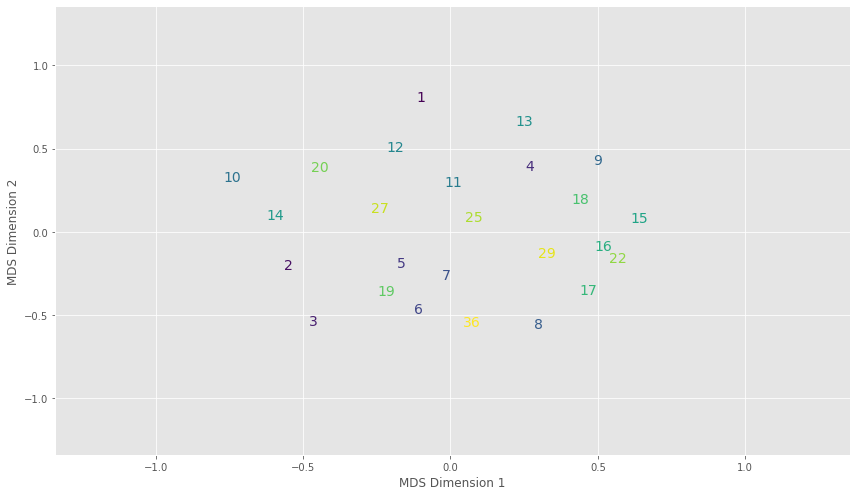

In [368]:
#plot the MDS plot
fig = plt.figure(figsize=(12,7))
plt.grid(True)


for i in range(len(relevant_clusters)):
    x = hotspot_coords[i][0]
    y = hotspot_coords[i][1]
#    plt.plot(x, y, 'bo')
    plt.text(x, y, str(relevant_clusters[i]), fontsize=14, color=colours(i))
    
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.xlim((hotspot_c_min, hotspot_c_max))
plt.ylim((hotspot_c_min, hotspot_c_max))
plt.tight_layout()

In [6]:
#read in gubbins csv results

gubbins_result_tables = {}
for filepath in gubbins_csv_file_paths:
    name = "_".join(filepath.split("/")[-1].split("_")[:2])
    gubbins_result_tables[name] = pd.read_csv(filepath, sep='\t')

for cluster in gubbins_result_tables:
    clusterno = int(cluster.split("_")[0].lstrip("cl"))
    gubbins_result_tables[cluster]["PopPUNK_cluster"] = [clusterno] * gubbins_result_tables[cluster].shape[0]

rho_thetas = [x[1][["Node","rho/theta", "PopPUNK_cluster"]] for x in gubbins_result_tables.items()]
rhotheta_df = pd.concat(rho_thetas, ignore_index=True)




In [4]:
cluster_data_frames = [pd.DataFrame(y) for x, y in rhotheta_df.groupby("PopPUNK_cluster")]
rho_theta_values = [x["rho/theta"] for x in cluster_data_frames]
cluster_rho_theta_test, cl_rho_theta_p = stats.kruskal(*rho_theta_values)

In [60]:
cluster_rho_theta_test

4129.647161205097

In [59]:
cl_rho_theta_p

0.0

In [64]:
np.finfo(float)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

In [85]:
posthoc_comparisons = sp.posthoc_dunn(rhotheta_df, val_col='rho/theta', group_col='PopPUNK_cluster', p_adjust = 'holm')

     1    2    3    4    5    6    7    8    9    10  ...   16   17   18   19  \
1  -1.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  ...  2.0  1.0  1.0  1.0   
2   0.0 -1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  ...  2.0  1.0  1.0  1.0   
3   1.0  1.0 -1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  0.0  0.0  0.0   
4   1.0  1.0  1.0 -1.0  0.0  1.0  1.0  3.0  1.0  1.0  ...  1.0  1.0  1.0  1.0   
5   1.0  1.0  1.0  0.0 -1.0  1.0  1.0  2.0  1.0  1.0  ...  1.0  1.0  1.0  1.0   
6   1.0  1.0  1.0  1.0  1.0 -1.0  0.0  1.0  1.0  1.0  ...  1.0  0.0  0.0  0.0   
7   1.0  1.0  1.0  1.0  1.0  0.0 -1.0  1.0  1.0  1.0  ...  1.0  0.0  0.0  0.0   
8   0.0  0.0  1.0  3.0  2.0  1.0  1.0 -1.0  0.0  1.0  ...  1.0  1.0  1.0  1.0   
9   0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0 -1.0  1.0  ...  0.0  1.0  1.0  1.0   
10  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0 -1.0  ...  0.0  1.0  3.0  1.0   
11  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0  1.0   
12  1.0  1.0  1.0  1.0  1.0 

TypeError: 'AxesSubplot' object does not support indexing

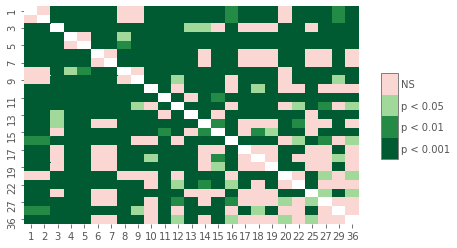

In [103]:
sp.sign_plot(posthoc_comparisons)[0]

In [105]:
mds = manifold.MDS(n_components=2, dissimilarity="precomputed")
projection = mds.fit(sp.sign_array(posthoc_comparisons))
coords = projection.embedding_
c_min = np.min(coords) - abs(np.quantile(coords, 0.05))
c_max = np.max(coords) + abs(np.quantile(coords, 0.05))

In [364]:
relevant_clusters = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,25,27,29,36]

In [367]:
colours = plt.get_cmap(None, 25)

In [170]:
colours(24)

(0.993248, 0.906157, 0.143936, 1.0)

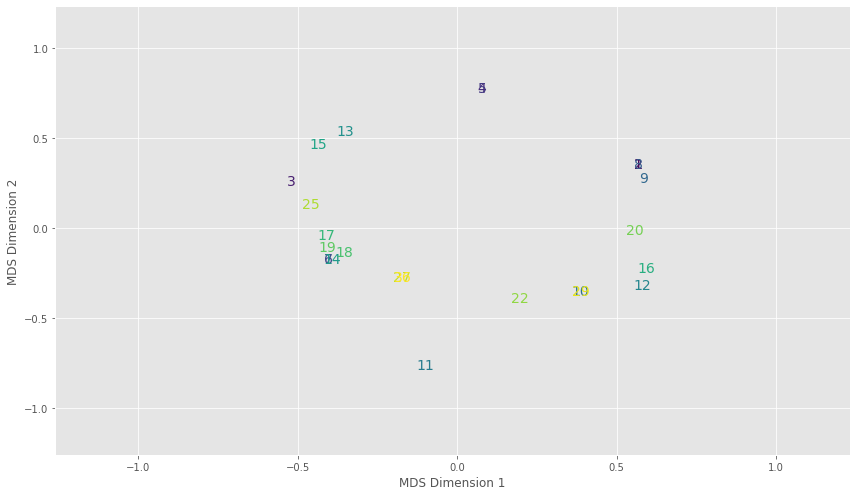

In [172]:
fig = plt.figure(figsize=(12,7))
plt.grid(True)


for i in range(len(relevant_clusters)):
    x = coords[i][0]
    y = coords[i][1]
#    plt.plot(x, y, 'bo')
    plt.text(x, y, str(relevant_clusters[i]), fontsize=14, color=colours(i))
    
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.xlim((c_min, c_max))
plt.ylim((c_min, c_max))
plt.tight_layout()

In [7]:
boxplot_clusters = ["Cluster_1",
                   "Cluster_2",
                   "Cluster_3",
                   "Cluster_4",
                   "Cluster_5",
                   "Cluster_6",
                   "Cluster_7",
                   "Cluster_8",
                   "Cluster_9",
                   "Cluster_10",
                   "Cluster_11",
                   "Cluster_12",
                   "Cluster_13",
                   "Cluster_14",
                   "Cluster_15",
                   "Cluster_16",
                   "Cluster_17",
                   "Cluster_18",
                   "Cluster_19",
                   "Cluster_20",
                   "Cluster_22",
                   "Cluster_25",
                   "Cluster_27",
                   "Cluster_29",
                   "Cluster_36"]

In [8]:
boxplot_data = {boxplot_clusters[i]: rho_theta_values[i] for i in range(len(boxplot_clusters))}

In [10]:
boxplot_data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in boxplot_data.items() ]))
boxprops = dict(linestyle='-', linewidth=2, color='k')

In [134]:
fig, ax = plt.subplots(figsize=(12, 7))
ax = boxplot_data.boxplot(column=boxplot_clusters, return_type='axes', showmeans=True, boxprops=boxprops)
#Add upper significance labels
#pos = np.arange(boxplot_data.shape[1]) + 1
#upper_labels = ["2,3,4,6,7,9", "1,4,5,7,8,9","1,4,5,7,8,9","1,2,3,5,6,9","2,3,4,6,9","1,4,5,7,9","1,2,3,6,9","2,3,9","1,2,3,4,5,6,7,8"]
#weights = ['bold', 'semibold']
#for tick, label in zip(range(len(boxplot_data)), ax.get_xticklabels()):
#    k = tick % 2
#    ax.text(pos[tick], .97, upper_labels[tick],
#             transform=ax.get_xaxis_transform(),
#             horizontalalignment='center', size='x-small',
#             weight=weights[k])
ax.set_ylabel(r'$\rho / \theta$')
plt.xticks(rotation=50)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25]),
 [Text(1, 0, 'Cluster_1'),
  Text(2, 0, 'Cluster_2'),
  Text(3, 0, 'Cluster_3'),
  Text(4, 0, 'Cluster_4'),
  Text(5, 0, 'Cluster_5'),
  Text(6, 0, 'Cluster_6'),
  Text(7, 0, 'Cluster_7'),
  Text(8, 0, 'Cluster_8'),
  Text(9, 0, 'Cluster_9'),
  Text(10, 0, 'Cluster_10'),
  Text(11, 0, 'Cluster_11'),
  Text(12, 0, 'Cluster_12'),
  Text(13, 0, 'Cluster_13'),
  Text(14, 0, 'Cluster_14'),
  Text(15, 0, 'Cluster_15'),
  Text(16, 0, 'Cluster_16'),
  Text(17, 0, 'Cluster_17'),
  Text(18, 0, 'Cluster_18'),
  Text(19, 0, 'Cluster_19'),
  Text(20, 0, 'Cluster_20'),
  Text(21, 0, 'Cluster_22'),
  Text(22, 0, 'Cluster_25'),
  Text(23, 0, 'Cluster_27'),
  Text(24, 0, 'Cluster_29'),
  Text(25, 0, 'Cluster_36')])

In [11]:
np.mean(boxplot_data)

Cluster_1     0.072160
Cluster_2     0.105827
Cluster_3     0.214228
Cluster_4     0.026242
Cluster_5     0.024745
Cluster_6     0.172330
Cluster_7     0.138770
Cluster_8     0.059915
Cluster_9     0.068541
Cluster_10    0.137377
Cluster_11    0.265125
Cluster_12    0.109378
Cluster_13    0.213307
Cluster_14    0.192693
Cluster_15    0.222079
Cluster_16    0.093876
Cluster_17    0.129821
Cluster_18    0.096305
Cluster_19    0.207046
Cluster_20    0.071927
Cluster_22    0.136272
Cluster_25    0.168570
Cluster_27    0.149126
Cluster_29    0.057711
Cluster_36    0.152248
dtype: float64

In [173]:
np.mean(rhotheta_df["rho/theta"])

0.11683482088610256

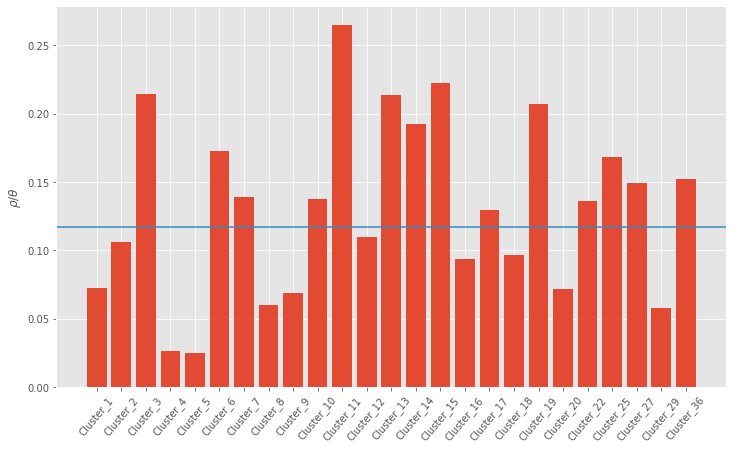

In [176]:
fig = plt.figure(figsize=(12,7))
plt.bar(np.mean(boxplot_data).index, np.mean(boxplot_data))
plt.xticks(rotation=50)
plt.ylabel(r'$\rho / \theta$')
plt.axhline(np.mean(rhotheta_df["rho/theta"]), color="C1")

In [19]:
gubbins_csv_file_paths

['./recombination_data/gubbins_perbranch_stats/cl4_alignment.noref.aln.per_branch_statistics.csv',
 './recombination_data/gubbins_perbranch_stats/cl8_alignment.noref.aln.per_branch_statistics.csv',
 './recombination_data/gubbins_perbranch_stats/cl16_alignment.noref.aln.per_branch_statistics.csv',
 './recombination_data/gubbins_perbranch_stats/cl22_alignment.noref.aln.per_branch_statistics.csv',
 './recombination_data/gubbins_perbranch_stats/cl5_alignment.noref.aln.per_branch_statistics.csv',
 './recombination_data/gubbins_perbranch_stats/cl17_alignment.noref.aln.per_branch_statistics.csv',
 './recombination_data/gubbins_perbranch_stats/cl9_alignment.noref.aln.per_branch_statistics.csv',
 './recombination_data/gubbins_perbranch_stats/cl14_alignment.noref.aln.per_branch_statistics.csv',
 './recombination_data/gubbins_perbranch_stats/cl18_alignment.noref.aln.per_branch_statistics.csv',
 './recombination_data/gubbins_perbranch_stats/cl6_alignment.noref.aln.per_branch_statistics.csv',
 './r

In [44]:
metadata = pd.read_csv("./metdata/latest_metadata_database.csv")

/Users/nm12/anaconda/envs/jupyter/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (12,16,17,19,20,21,22,23,24,26,27,29,33,34,35,36,37,39,46,48,51,52,53,54,55,56,57,59,67,80,81) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
relevant_metadata = metadata[["ENA_sample_accessions", "year", "country", "disease", "continent"]]

In [7]:
rhotheta_df.columns = ['ENA_sample_accessions', 'rho/theta', 'PopPUNK_cluster']

In [47]:
recombination_metadata = pd.merge(relevant_metadata, rhotheta_df, how="right")

In [51]:
recombination_metadata.dropna()[["ENA_sample_accessions", "year", "country", "PopPUNK_cluster", "rho/theta"]].to_csv("./recombination_data/assosciation_metadata.tsv", index=False, sep='\t')

In [66]:
recombination_metadata[["year", "rho/theta"]].boxplot(column="rho/theta", by="year", return_type='axes', showmeans=True, boxprops=boxprops, rot=70, figsize=(12,7))

rho/theta    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

In [80]:
year_data_frames = [pd.DataFrame(y) for x, y in recombination_metadata[recombination_metadata["year"]>2015].groupby("year")]
rho_theta_byyear_values = [x["rho/theta"] for x in year_data_frames]
year_rho_theta_test, year_rho_theta_p = stats.kruskal(*rho_theta_byyear_values)

In [81]:
year_rho_theta_p

0.002255206010259402

        2016.0  2017.0  2018.0  2019.0  2020.0
2016.0    -1.0     0.0     0.0     3.0     0.0
2017.0     0.0    -1.0     0.0     2.0     0.0
2018.0     0.0     0.0    -1.0     0.0     0.0
2019.0     3.0     2.0     0.0    -1.0     0.0
2020.0     0.0     0.0     0.0     0.0    -1.0
-----------


(<AxesSubplot:>, <matplotlib.colorbar.ColorbarBase at 0x12397d6d8>)

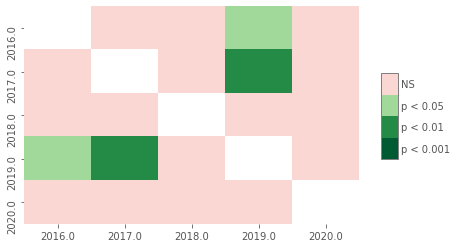

In [83]:
sp.sign_plot(sp.posthoc_dunn(recombination_metadata[recombination_metadata["year"]>2015], val_col='rho/theta', group_col='year', p_adjust = 'holm'))

rho/theta    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

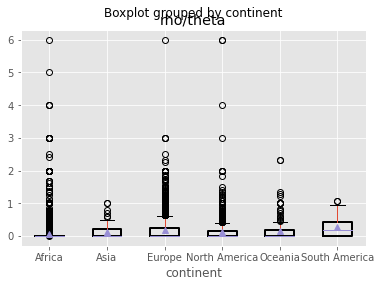

In [19]:
recombination_metadata[["continent", "rho/theta"]].boxplot(column="rho/theta", by="continent", return_type='axes', showmeans=True, boxprops=boxprops)

In [20]:
continent_data_frames = [pd.DataFrame(y) for x, y in recombination_metadata.groupby("continent")]
continent_rho_theta_values = [x["rho/theta"] for x in continent_data_frames]
continent_rho_theta_test, continent_rho_theta_p = stats.kruskal(*continent_rho_theta_values)

In [21]:
continent_rho_theta_p

9.746892059648605e-231

In [22]:
continent_posthoc_comparisons = sp.posthoc_dunn(recombination_metadata.dropna(), val_col='rho/theta', group_col='continent', p_adjust = 'holm')

               Africa  Asia  Europe  North America  Oceania  South America
Africa           -1.0   1.0     1.0            1.0      1.0            1.0
Asia              1.0  -1.0     0.0            0.0      0.0            2.0
Europe            1.0   0.0    -1.0            1.0      3.0            1.0
North America     1.0   0.0     1.0           -1.0      0.0            1.0
Oceania           1.0   0.0     3.0            0.0     -1.0            1.0
South America     1.0   2.0     1.0            1.0      1.0           -1.0
-----------


(<AxesSubplot:>, <matplotlib.colorbar.ColorbarBase at 0x120f41438>)

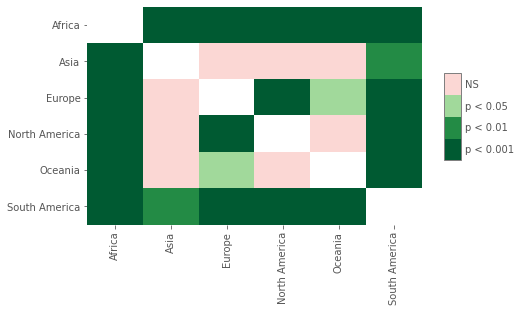

In [23]:
sp.sign_plot(continent_posthoc_comparisons)

rho/theta    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

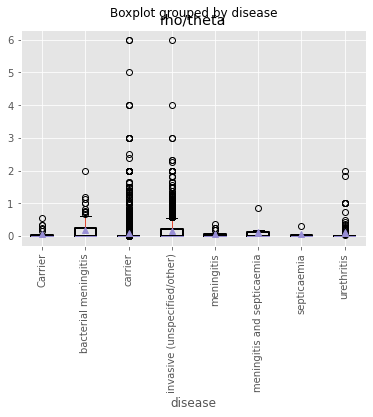

In [79]:
recombination_metadata[["disease", "rho/theta"]].boxplot(column="rho/theta", by="disease", return_type='axes', showmeans=True, boxprops=boxprops, rot=90)

In [55]:
recombination_metadata['disease'] = recombination_metadata['disease'].replace(["Carrier"], "carrier")

In [53]:
recombination_metadata['disease'] = recombination_metadata['disease'].replace(["invasive (unspecified/other)"], "invasive")
recombination_metadata['disease'] = recombination_metadata['disease'].replace(["bacterial meningitis"], "invasive")
recombination_metadata['disease'] = recombination_metadata['disease'].replace(["meningitis"], "invasive")
recombination_metadata['disease'] = recombination_metadata['disease'].replace(["meningitis and septicaemia"], "invasive")
recombination_metadata['disease'] = recombination_metadata['disease'].replace(["septicaemia"], "invasive")
recombination_metadata['disease'] = recombination_metadata['disease'].replace(["urethritis"], "invasive")

rho/theta    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

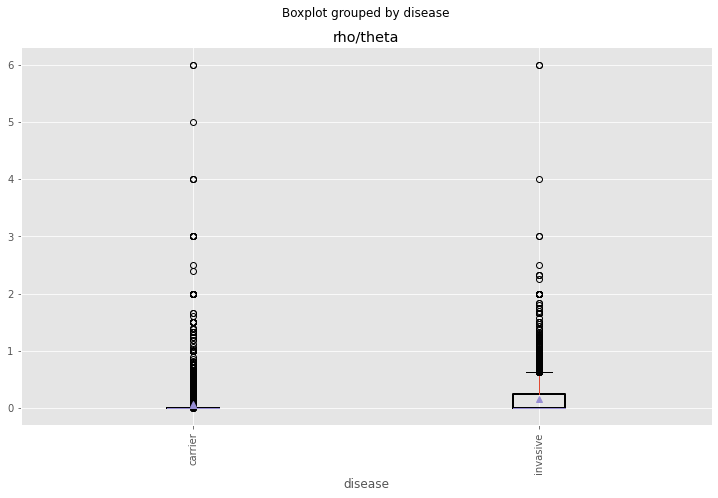

In [56]:
recombination_metadata[["disease", "rho/theta"]].boxplot(column="rho/theta", by="disease", return_type='axes', showmeans=True, boxprops=boxprops, rot=90, figsize=(12,7))

In [239]:
disease_data_frames = [pd.DataFrame(y) for x, y in recombination_metadata.groupby("disease")]
disease_rho_theta_values = [x["rho/theta"] for x in disease_data_frames]

In [102]:
stats.mannwhitneyu(disease_rho_theta_values[0], disease_rho_theta_values[1], alternative="two-sided")

MannwhitneyuResult(statistic=8494146.5, pvalue=5.67507290287964e-136)

In [253]:
disease_data_frames[0]["disease"].value_counts()

carrier    5682
Name: disease, dtype: int64

In [106]:
print("carrier")
disease_data_frames[0]["rho/theta"].mean()

carrier


0.08079269026548673

In [107]:
print("disease")
disease_data_frames[1]["rho/theta"].mean()

disease


0.15101634561626429

In [28]:
recombination_metadata[]

SyntaxError: invalid syntax (<ipython-input-28-d472961d1b7a>, line 1)

In [29]:
recombination_metadata[["ENA_sample_accessions", "rho/theta"]].to_csv("./metdata/recombination_phenotypes.tsv", sep="\t", index=False)

In [30]:
recombination_metadata[["ENA_sample_accessions", "year", "PopPUNK_cluster", "continent"]].to_csv("./metdata/covariate_phenotypes.tsv", sep="\t", index=False, na_rep="NA")

## Let's look at disease, but split up within clusters. Does the same pattern hold?

rho/theta    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

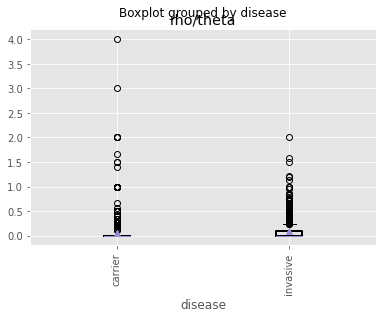

In [20]:
recombination_metadata[recombination_metadata["PopPUNK_cluster"]==1].boxplot(column="rho/theta", by="disease", return_type='axes', showmeans=True, boxprops=boxprops, rot=90)

rho/theta    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

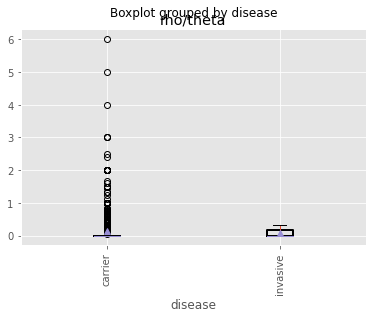

In [21]:
recombination_metadata[recombination_metadata["PopPUNK_cluster"]==2].boxplot(column="rho/theta", by="disease", return_type='axes', showmeans=True, boxprops=boxprops, rot=90)

rho/theta    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

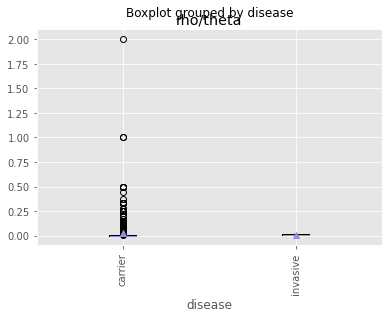

In [23]:
recombination_metadata[recombination_metadata["PopPUNK_cluster"]==4].boxplot(column="rho/theta", by="disease", return_type='axes', showmeans=True, boxprops=boxprops, rot=90)

rho/theta    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

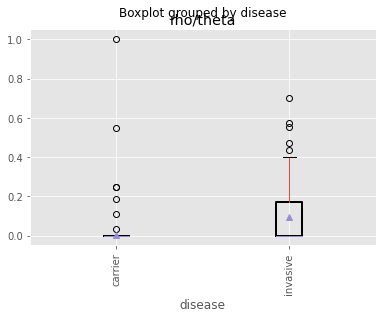

In [24]:
recombination_metadata[recombination_metadata["PopPUNK_cluster"]==5].boxplot(column="rho/theta", by="disease", return_type='axes', showmeans=True, boxprops=boxprops, rot=90)

rho/theta    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

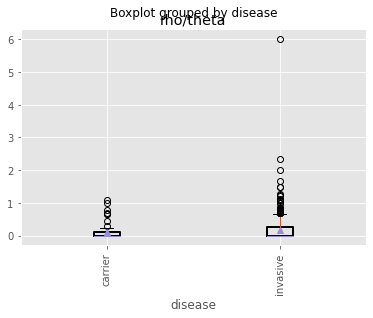

In [25]:
recombination_metadata[recombination_metadata["PopPUNK_cluster"]==6].boxplot(column="rho/theta", by="disease", return_type='axes', showmeans=True, boxprops=boxprops, rot=90)

rho/theta    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

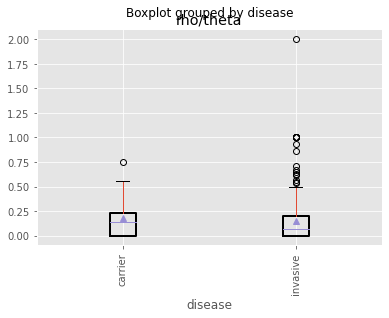

In [26]:
recombination_metadata[recombination_metadata["PopPUNK_cluster"]==7].boxplot(column="rho/theta", by="disease", return_type='axes', showmeans=True, boxprops=boxprops, rot=90)

rho/theta    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

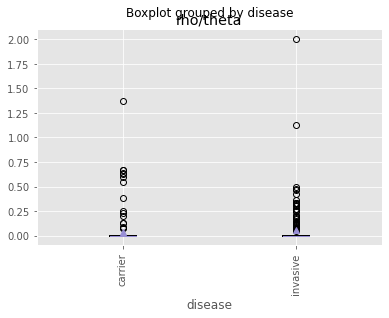

In [27]:
recombination_metadata[recombination_metadata["PopPUNK_cluster"]==8].boxplot(column="rho/theta", by="disease", return_type='axes', showmeans=True, boxprops=boxprops, rot=90)

rho/theta    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

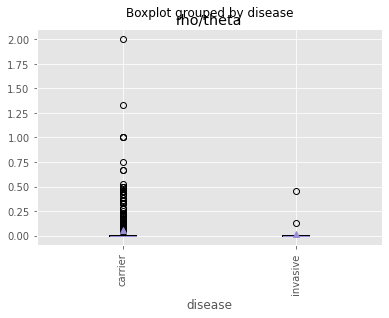

In [28]:
recombination_metadata[recombination_metadata["PopPUNK_cluster"]==9].boxplot(column="rho/theta", by="disease", return_type='axes', showmeans=True, boxprops=boxprops, rot=90)

rho/theta    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

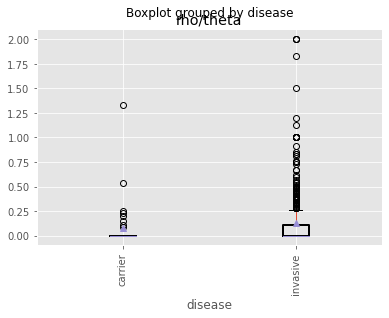

In [29]:
recombination_metadata[recombination_metadata["PopPUNK_cluster"]==10].boxplot(column="rho/theta", by="disease", return_type='axes', showmeans=True, boxprops=boxprops, rot=90)

rho/theta    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

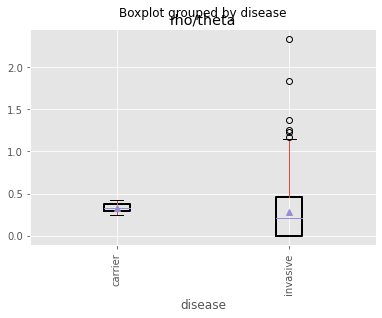

In [30]:
recombination_metadata[recombination_metadata["PopPUNK_cluster"]==11].boxplot(column="rho/theta", by="disease", return_type='axes', showmeans=True, boxprops=boxprops, rot=90)

rho/theta    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

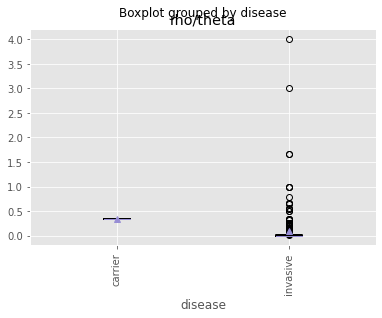

In [31]:
recombination_metadata[recombination_metadata["PopPUNK_cluster"]==12].boxplot(column="rho/theta", by="disease", return_type='axes', showmeans=True, boxprops=boxprops, rot=90)

rho/theta    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

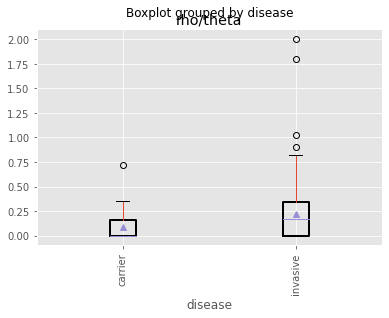

In [32]:
recombination_metadata[recombination_metadata["PopPUNK_cluster"]==13].boxplot(column="rho/theta", by="disease", return_type='axes', showmeans=True, boxprops=boxprops, rot=90)

In [240]:
cl1_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 1]["rho/theta"] for x in disease_data_frames]
cl2_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 2]["rho/theta"] for x in disease_data_frames]
cl3_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 3]["rho/theta"] for x in disease_data_frames]
cl4_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 4]["rho/theta"] for x in disease_data_frames]
cl5_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 5]["rho/theta"] for x in disease_data_frames]
cl6_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 6]["rho/theta"] for x in disease_data_frames]
cl7_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 7]["rho/theta"] for x in disease_data_frames]
cl8_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 8]["rho/theta"] for x in disease_data_frames]
cl9_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 9]["rho/theta"] for x in disease_data_frames]
cl10_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 10]["rho/theta"] for x in disease_data_frames]
cl11_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 11]["rho/theta"] for x in disease_data_frames]
cl12_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 12]["rho/theta"] for x in disease_data_frames]
cl13_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 13]["rho/theta"] for x in disease_data_frames]
cl14_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 14]["rho/theta"] for x in disease_data_frames]
cl15_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 15]["rho/theta"] for x in disease_data_frames]
cl16_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 16]["rho/theta"] for x in disease_data_frames]
cl17_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 17]["rho/theta"] for x in disease_data_frames]
cl18_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 18]["rho/theta"] for x in disease_data_frames]
cl19_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 19]["rho/theta"] for x in disease_data_frames]
cl20_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 20]["rho/theta"] for x in disease_data_frames]
cl22_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 22]["rho/theta"] for x in disease_data_frames]
cl25_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 25]["rho/theta"] for x in disease_data_frames]
cl27_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 27]["rho/theta"] for x in disease_data_frames]
cl29_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 29]["rho/theta"] for x in disease_data_frames]
cl36_disease_rho_theta_values = [x[x["PopPUNK_cluster"] == 36]["rho/theta"] for x in disease_data_frames]

In [38]:
stats.mannwhitneyu(cl1_disease_rho_theta_values[0], cl1_disease_rho_theta_values[1], alternative="two-sided")

MannwhitneyuResult(statistic=340752.5, pvalue=2.3184910849450974e-36)

In [40]:
stats.mannwhitneyu(cl2_disease_rho_theta_values[0], cl2_disease_rho_theta_values[1], alternative="two-sided")

MannwhitneyuResult(statistic=6686.5, pvalue=0.353182680724377)

In [243]:
stats.mannwhitneyu(cl8_disease_rho_theta_values[0], cl8_disease_rho_theta_values[1], alternative="two-sided")

MannwhitneyuResult(statistic=16328.5, pvalue=0.0013815966925475557)

In [241]:
stats.mannwhitneyu(cl25_disease_rho_theta_values[0], cl25_disease_rho_theta_values[1], alternative="two-sided")

MannwhitneyuResult(statistic=1018.0, pvalue=0.021164288632465746)

In [242]:
stats.mannwhitneyu(cl27_disease_rho_theta_values[0], cl27_disease_rho_theta_values[1], alternative="two-sided")

MannwhitneyuResult(statistic=490.0, pvalue=1.7576387413821401e-06)

That's some interesting data exploration and analysis, but now let's prepare some figures and numbers for writing up these results in Chapter 4 of the thesis

Text(0.5, 0, '$\\rho/ \\theta}$')

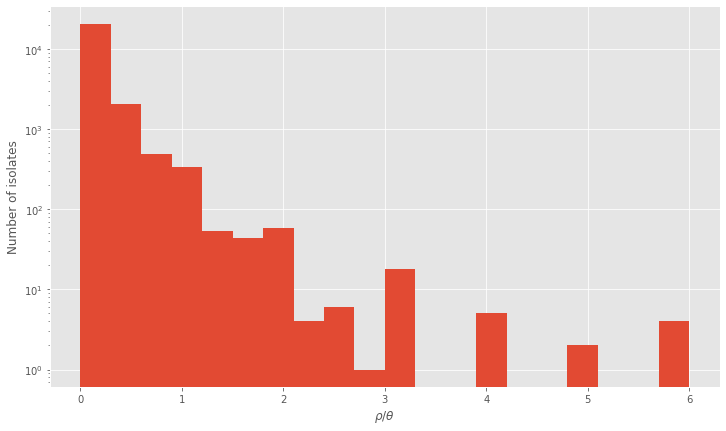

In [10]:
rhotheta_df[["rho/theta"]].hist(bins=20, log=True, figsize=(12,7))
plt.title("")
plt.ylabel(r'Number of isolates')
plt.xlabel(r"$\rho/ \theta}$")

Node  rho/theta  PopPUNK_cluster
2386   internal_800   0.000000                8
3766   internal_800   0.124031               22
5142   internal_800   0.016667                5
6331   internal_800   0.000000                9
7884   internal_800   0.257143                6
10168  internal_800   0.000000                7
17821  internal_800   0.000000               10

In [178]:
mean_recombination_rates = np.mean(boxplot_data)

In [229]:
disease_percents = []
for cluster in relevant_clusters:
    cluster_df = recombination_metadata[recombination_metadata["PopPUNK_cluster"]==cluster].dropna(subset=["disease"])
    disease_pc = cluster_df[cluster_df["disease"]=="invasive"].shape[0]/float(cluster_df.shape[0])
    disease_percents.append(disease_pc)

In [237]:
disease_percents

[0.46312997347480106,
 0.007942238267148015,
 0.9602977667493796,
 0.0012804097311139564,
 0.11525974025974026,
 0.8990228013029316,
 0.9069767441860465,
 0.5629820051413882,
 0.07194244604316546,
 0.9268774703557312,
 0.9936102236421726,
 0.9962264150943396,
 0.881578947368421,
 1.0,
 1.0,
 0.016483516483516484,
 0.047619047619047616,
 0.8947368421052632,
 0.1141552511415525,
 0.8484848484848485,
 0.011235955056179775,
 0.37037037037037035,
 0.23636363636363636,
 0.04,
 0.07766990291262135]

In [230]:
temp = pd.DataFrame(np.mean(boxplot_data))

In [231]:
temp["disease_pc"] = disease_percents

In [232]:
temp.columns = ["rho/theta", "disease_pc"]

Text(0, 0.5, 'Invasive disease %')

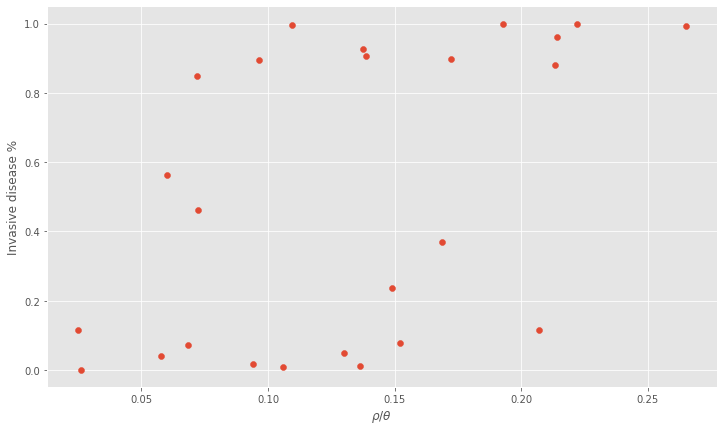

In [235]:
fig = plt.figure(figsize=(12,7))
plt.scatter(temp["rho/theta"], temp["disease_pc"])
plt.xlabel(r'$\rho / \theta$')
plt.ylabel("Invasive disease %")

In [236]:
stats.spearmanr(temp["rho/theta"], temp["disease_pc"])

SpearmanrResult(correlation=0.5616464808645618, pvalue=0.003483202043886959)

# Let's restrict ourselves to the BF data again for a moment to put it into the global context

In [211]:
metadata[metadata["project_accession"] == "ERP014166"]["poppunk_cluster"].value_counts()

2      1353
5       537
1       373
9       180
16      135
4        90
8        86
29       22
34       12
74        9
115       5
138       4
180       3
178       3
182       3
269       2
38        1
481       1
85        1
181       1
478       1
477       1
480       1
179       1
23        1
479       1
476       1
Name: poppunk_cluster, dtype: int64

In [212]:
temp2 = metadata[metadata["project_accession"] == "ERP014166"]

In [53]:
temp2[temp2["poppunk_cluster"]=="1"]

NameError: name 'temp2' is not defined

In [222]:
temp2[temp2["ENA_sample_accessions"]=="ERS1113969"]

ENA_sample_accessions ENA_run_accessions  \
9789            ERS1113969         ERR1608402   

                                               data_loc project_accession  \
9789  /lustre/scratch118/infgen/pathogen/pathpipe/pr...         ERP014166   

                     species    year       country  disease    region  \
9789  Neisseria meningitidis  2012.0  Burkina Faso  carrier  Bogodogo   

     continent  ... aroE fumC gdh  pdhC  pgm  mismatches uncertainty    depth  \
9789    Africa  ...   17   15  14     7   12           0           -  42.5316   

         maxMAF poppunk_cluster  
9789  0.0740741              29  

[1 rows x 83 columns]

In [273]:
print(metadata["poppunk_cluster"].value_counts())

1       2218
2       1436
3        881
4        816
6        733
        ... 
829        1
843        1
1135       1
1138       1
862        1
Name: poppunk_cluster, Length: 1262, dtype: int64


In [445]:
cluster_gene_names["cl36_alignment.noref.aln.recombination"]

{255: ['No gene name'],
 325: ['No gene name', 'piiC_2'],
 356: ['pilE_6', 'No gene name'],
 357: ['pilE_7', 'pilE_8'],
 358: ['pilE_8', 'pilE_9'],
 359: ['lpxC'],
 895: ['No gene name', 'lex1_1'],
 896: ['lex1_1', 'lex1_2'],
 897: ['lex1_2'],
 898: ['rsmE'],
 899: ['rsmE', 'cysQ'],
 933: ['ydfG', 'No gene name'],
 934: ['lst'],
 935: ['lst', 'icd'],
 1325: ['tbp1'],
 1326: ['tbp1'],
 1327: ['tbp1', 'tbpB'],
 1328: ['tbpB'],
 1329: ['tbpB'],
 1330: ['racE'],
 1331: ['racE', 'tsaE', 'amiC'],
 1332: ['amiC']}

In [422]:
#Let's check cl27 to see if tbp recombinations are really short
cl2_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl2_alignment.noref.aln.recombination_predictions.gff')
cl3_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl3_alignment.noref.aln.recombination_predictions.gff')
cl4_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl4_alignment.noref.aln.recombination_predictions.gff')
cl5_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl5_alignment.noref.aln.recombination_predictions.gff')
cl6_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl6_alignment.noref.aln.recombination_predictions.gff')
cl7_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl7_alignment.noref.aln.recombination_predictions.gff')
cl8_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl8_alignment.noref.aln.recombination_predictions.gff')
cl9_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl9_alignment.noref.aln.recombination_predictions.gff')
cl10_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl10_alignment.noref.aln.recombination_predictions.gff')
cl11_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl11_alignment.noref.aln.recombination_predictions.gff')
cl12_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl12_alignment.noref.aln.recombination_predictions.gff')
cl13_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl13_alignment.noref.aln.recombination_predictions.gff')
cl14_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl14_alignment.noref.aln.recombination_predictions.gff')
cl15_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl15_alignment.noref.aln.recombination_predictions.gff')
cl16_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl16_alignment.noref.aln.recombination_predictions.gff')
cl17_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl17_alignment.noref.aln.recombination_predictions.gff')
cl18_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl18_alignment.noref.aln.recombination_predictions.gff')
cl19_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl19_alignment.noref.aln.recombination_predictions.gff')
cl20_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl20_alignment.noref.aln.recombination_predictions.gff')
cl22_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl22_alignment.noref.aln.recombination_predictions.gff')
cl25_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl25_alignment.noref.aln.recombination_predictions.gff')
cl29_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl29_alignment.noref.aln.recombination_predictions.gff')
cl36_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl36_alignment.noref.aln.recombination_predictions.gff')
cl27_parsed = get_gubbins_cords_and_genomeLegnth('./recombination_data/gubbins_recombination_gffs/cl27_alignment.noref.aln.recombination_predictions.gff')

In [446]:
cl2_tbp_repeats = [x for x in cl2_parsed["coords"] if (476000 < x[0] < 482000) or (476000 < x[1] < 482000)]
cl3_tbp_repeats = [x for x in cl3_parsed["coords"] if (1494000 < x[0] < 149600) or (1494000 < x[1] < 149600)]
cl4_tbp_repeats = [x for x in cl4_parsed["coords"] if (1660000 < x[0] < 1665000) or (1660000 < x[1] < 1665000)]
cl5_tbp_repeats = [x for x in cl5_parsed["coords"] if (1763000 < x[0] < 1766000) or (1763000 < x[1] < 1776000)]
cl6_tbp_repeats = [x for x in cl6_parsed["coords"] if (1743000 < x[0] < 1749000) or (1743000 < x[1] < 1749000)]
cl7_tbp_repeats = [x for x in cl7_parsed["coords"] if (2069000 < x[0] < 2075000) or (2069000 < x[1] < 2075000)]
cl8_tbp_repeats = [x for x in cl8_parsed["coords"] if (1216000 < x[0] < 1221000) or (1216000 < x[1] < 1221000)]
cl9_tbp_repeats = [x for x in cl9_parsed["coords"] if (444000 < x[0] < 449000) or (444000 < x[1] < 449000)]
cl11_tbp_repeats = [x for x in cl11_parsed["coords"] if (1605000 < x[0] < 1610000) or (1605000 < x[1] < 1610000)]
cl12_tbp_repeats = [x for x in cl12_parsed["coords"] if (200000 < x[0] < 205000) or (200000 < x[1] < 205000)]
cl13_tbp_repeats = [x for x in cl13_parsed["coords"] if (435000 < x[0] < 440000) or (435000 < x[1] < 440000)]
cl14_tbp_repeats = [x for x in cl14_parsed["coords"] if (1349000 < x[0] < 1353000) or (1349000 < x[1] < 1353000)]
cl15_tbp_repeats = [x for x in cl15_parsed["coords"] if (1790000 < x[0] < 1793000) or (1790000 < x[1] < 1793000)]
cl16_tbp_repeats = [x for x in cl16_parsed["coords"] if (1909000 < x[0] < 1915000) or (1909000 < x[1] < 1915000)]
cl17_tbp_repeats = [x for x in cl17_parsed["coords"] if (803000 < x[0] < 808000) or (803000 < x[1] < 808000)]
cl18_tbp_repeats = [x for x in cl18_parsed["coords"] if (1953000 < x[0] < 1957000) or (1953000 < x[1] < 1957000)]
cl19_tbp_repeats = [x for x in cl19_parsed["coords"] if (630000 < x[0] < 635000) or (630000 < x[1] < 635000)]
cl20_tbp_repeats = [x for x in cl20_parsed["coords"] if (2000 < x[0] < 4000) or (2000 < x[1] < 4000)]
cl22_tbp_repeats = [x for x in cl22_parsed["coords"] if (1432000 < x[0] < 1437000) or (1432000 < x[1] < 1437000)]
cl25_tbp_repeats = [x for x in cl25_parsed["coords"] if (1951000 < x[0] < 1956000) or (1951000 < x[1] < 1956000)]
cl29_tbp_repeats = [x for x in cl29_parsed["coords"] if (614000 < x[0] < 619000) or (614000 < x[1] < 619000)]
cl36_tbp_repeats = [x for x in cl36_parsed["coords"] if (1325000 < x[0] < 1330000) or (1325000 < x[1] < 1330000)]
cl27_tbp_repeats = [x for x in cl27_parsed["coords"] if (700000 < x[0] < 705000) or (700000 < x[1] < 705000)]

In [449]:
all_repeats = [cl2_tbp_repeats,cl3_tbp_repeats,cl4_tbp_repeats,cl5_tbp_repeats,cl6_tbp_repeats,cl7_tbp_repeats,
               cl8_tbp_repeats,cl9_tbp_repeats,cl11_tbp_repeats,cl12_tbp_repeats,cl13_tbp_repeats,cl14_tbp_repeats,
               cl15_tbp_repeats,cl16_tbp_repeats,cl17_tbp_repeats,cl18_tbp_repeats,cl19_tbp_repeats,cl20_tbp_repeats,
               cl22_tbp_repeats,cl25_tbp_repeats,cl27_tbp_repeats,cl29_tbp_repeats, cl36_tbp_repeats]

In [450]:
all_lengths = []
for repeats in all_repeats:
    lengths = []
    for repeat_coord in repeats:
        lengths.append(repeat_coord[1]-repeat_coord[0])
    all_lengths.append(lengths)


In [454]:
average_lengths = []
for lengths in all_lengths:
    average_lengths.append(np.mean(lengths))

/Users/nm12/anaconda/envs/jupyter/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nm12/anaconda/envs/jupyter/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [461]:
max(average_lengths)

6975.821428571428

In [458]:
joined_lengths = []
for lengths in all_lengths:
    joined_lengths += lengths
np.mean(joined_lengths)

4904.652191395256

In [2]:
#Look at spydrpick results
#Clusters with extreme outliers: 3,11,15,19,22
spydrpick_file_paths = ["./recombination_data/spydrpick_output/outlier_files/" + x for x in os.listdir("./recombination_data/spydrpick_output/outlier_files/")]

In [3]:
spydrpick_results = {}
for filepath in spydrpick_file_paths:
    name = filepath.split("/")[-1].split("_")[0]
    spydrpick_results[name] = pd.read_csv(filepath, delim_whitespace=True, names=["pos1", "pos2", "genome_distance", "ARACNE", "MI", "MI_wo_gaps", "gap_effect", "extreme_outlier"])

In [4]:
cluster_references_spy = {"cl1":"./recombination_data/reference_annotations/cluster_1_reference.gff",
                      "cl2":"./recombination_data/reference_annotations/cluster_2_reference.gff",
                      "cl3":"./recombination_data/reference_annotations/cluster_3_reference.gff",
                      "cl4":"./recombination_data/reference_annotations/cluster_4_reference_joined.gff",
                      "cl5":"./recombination_data/reference_annotations/cluster_5_reference.gff",
                      "cl6":"./recombination_data/reference_annotations/cluster_6_reference.gff",
                      "cl7":"./recombination_data/reference_annotations/cluster_7_reference_joined.gff",
                      "cl8":"./recombination_data/reference_annotations/cluster_8_reference.gff",
                      "cl9":"./recombination_data/reference_annotations/cluster_9_reference_joined.gff",
                      "cl10":"./recombination_data/reference_annotations/cluster_10_reference.gff",
                      "cl11":"./recombination_data/reference_annotations/cluster_11_reference_joined.gff",
                      "cl12":"./recombination_data/reference_annotations/cluster_12_reference_joined.gff",
                      "cl13":"./recombination_data/reference_annotations/cluster_13_reference_joined.gff",
                      "cl14":"./recombination_data/reference_annotations/cluster_14_reference.gff",
                      "cl15":"./recombination_data/reference_annotations/cluster_15_reference.gff",
                      "cl16":"./recombination_data/reference_annotations/cluster_16_reference_joined.gff",
                      "cl17":"./recombination_data/reference_annotations/cluster_17_reference_joined.gff",
                      "cl18":"./recombination_data/reference_annotations/cluster_18_reference_joined.gff",
                      "cl19":"./recombination_data/reference_annotations/cluster_19_reference_joined.gff",
                      "cl20":"./recombination_data/reference_annotations/cluster_20_reference_joined.gff",
                      "cl22":"./recombination_data/reference_annotations/cluster_22_reference_joined.gff",
                      "cl25":"./recombination_data/reference_annotations/cluster_25_reference_joined.gff",
                      "cl27":"./recombination_data/reference_annotations/cluster_27_reference_joined.gff",
                      "cl29":"./recombination_data/reference_annotations/cluster_29_reference_joined.gff",
                      "cl36":"./recombination_data/reference_annotations/cluster_36_reference_joined.gff"
                     }

In [9]:
count = 0
spyderpick_result_genes = {}
for clusterid in spydrpick_results:
    spyderpick_result_genes[clusterid] = []
    gene_positions_and_names = get_gene_cords(cluster_references_spy[clusterid])
    #limit to extreme outliers
    outliers = spydrpick_results[clusterid][spydrpick_results[clusterid]["extreme_outlier"]==1]
    if outliers.shape[0] >= 1:
        print("\n\n------" + clusterid + "------")
    for row in outliers.iterrows():
        count +=1
        for index in range(len(gene_positions_and_names["positions"])):
            if (gene_positions_and_names["positions"][index][0] < row[1]["pos1"]) and (row[1]["pos1"] < gene_positions_and_names["positions"][index][1]):
                print("pos1: " + str(row[1]["pos1"]) + " is in " + gene_positions_and_names["names"][index])
                print(gene_positions_and_names["products"][index])
                spyderpick_result_genes[clusterid].append(gene_positions_and_names["ids"][index])
            if (gene_positions_and_names["positions"][index][0] < row[1]["pos2"]) and (row[1]["pos2"] < gene_positions_and_names["positions"][index][1]):
                print("pos2: " + str(row[1]["pos2"]) + " is in " + gene_positions_and_names["names"][index])
                print(gene_positions_and_names["products"][index])
                spyderpick_result_genes[clusterid].append(gene_positions_and_names["ids"][index])                
        
        



------cl15------
pos1: 2118239.0 is in tufA_1
Elongation factor Tu
pos2: 2118240.0 is in tufA_1
Elongation factor Tu
pos1: 1032521.0 is in No gene name
hypothetical protein
pos2: 1032522.0 is in No gene name
hypothetical protein
pos1: 2145198.0 is in zraR
Transcriptional regulatory protein ZraR
pos2: 2145200.0 is in zraR
Transcriptional regulatory protein ZraR
pos1: 1037481.0 is in No gene name
hypothetical protein
pos2: 1037487.0 is in No gene name
hypothetical protein
pos1: 2154536.0 is in pyrB
Aspartate carbamoyltransferase catalytic subunit
pos2: 2154537.0 is in pyrB
Aspartate carbamoyltransferase catalytic subunit
pos1: 1202467.0 is in No gene name
hypothetical protein
pos2: 1202474.0 is in No gene name
hypothetical protein
pos1: 587039.0 is in btuB
Vitamin B12 transporter BtuB
pos2: 587040.0 is in btuB
Vitamin B12 transporter BtuB


------cl11------
pos1: 1675790.0 is in No gene name
hypothetical protein
pos2: 1675792.0 is in No gene name
hypothetical protein
pos1: 1824421.0 is

In [512]:
count

45

In [14]:
for key in spyderpick_result_genes:
    if len(spyderpick_result_genes[key]) > 0:
        print(key)
        print(len(set(spyderpick_result_genes[key])))
        print(set(spyderpick_result_genes[key]))

cl15
7
{'ID=LGAGABAL_01078', 'ID=LGAGABAL_02033', 'ID=LGAGABAL_02005', 'ID=LGAGABAL_02042', 'ID=LGAGABAL_00906', 'ID=LGAGABAL_00523', 'ID=LGAGABAL_00912'}
cl11
2
{'ID=IFNMAEED_01626', 'ID=IFNMAEED_01763'}
cl3
2
{'ID=JLJPIEMD_01533', 'ID=JLJPIEMD_00992'}
cl19
9
{'ID=EPFKJHMC_01402', 'ID=EPFKJHMC_00218', 'ID=EPFKJHMC_01085', 'ID=EPFKJHMC_00212', 'ID=EPFKJHMC_01611', 'ID=EPFKJHMC_00214', 'ID=EPFKJHMC_00213', 'ID=EPFKJHMC_01091', 'ID=EPFKJHMC_00211'}
cl22
1
{'ID=FKFHMGCE_01049'}


In [16]:
spydrpick_results["cl19"][spydrpick_results["cl19"]["extreme_outlier"]==1]

pos1     pos2  genome_distance  ARACNE        MI  MI_wo_gaps  \
0    201173   201475              302       1  0.531170    0.415509   
1    202846   202852                6       1  0.528765    0.419012   
2    202846   203088              242       1  0.528765    0.419012   
3    202852   203088              236       1  0.528765    0.419012   
4    202846   203292              446       1  0.527841    0.418840   
5    202852   203292              440       1  0.527841    0.418840   
6    203088   203292              204       1  0.527841    0.418840   
7    202992   202995                3       1  0.526771    0.415965   
8    202846   202995              149       1  0.515572    0.400046   
9    202852   202995              143       1  0.515572    0.400046   
10   202995   203088               93       1  0.515572    0.400046   
11   202995   203292              297       0  0.514656    0.399863   
12   202992   203088               96       0  0.514362    0.398305   
13   202846   202992              146       0  0.514362    0.398305   
14   202852   202992              140       0  0.514362    0.398305   
15   203254   203292               38       1  0.514008    0.415816   
16   202992   203292              300       0  0.513446    0.398121   
17   202846   203254              408       0  0.513075    0.415816   
18   202852   203254              402       0  0.513075    0.415816   
19   203088   203254              166       0  0.513075    0.415816   
20  1081793  1081807               14       1  0.511350    0.384834   
21  1082011  1082014                3       1  0.509973    0.432809   
22  1427796  1427798                2       1  0.507047    0.430195   
23   208518   208533               15       1  0.505618    0.398887   
24   203586   203592                6       1  0.504581    0.324772   
25  1674066  1674069                3       1  0.503746    0.404872   
26  1091790  1091793                3       1  0.502935    0.382059   
27   203756   203765                9       1  0.502244    0.321802   
28   202995   203254              259       0  0.500033    0.396645   
29   203010   203016                6       1  0.499934    0.387389   
30   203532   203538                6       1  0.499071    0.386417   
31   202992   203254              262       0  0.498838    0.394885   
32  1429382  1429385                3       1  0.498807    0.425215   

    gap_effect  extreme_outlier  
0         21.8                1  
1         20.8                1  
2         20.8                1  
3         20.8                1  
4         20.7                1  
5         20.7                1  
6         20.7                1  
7         21.0                1  
8         22.4                1  
9         22.4                1  
10        22.4                1  
11        22.3                1  
12        22.6                1  
13        22.6                1  
14        22.6                1  
15        19.1                1  
16        22.5                1  
17        19.0                1  
18        19.0                1  
19        19.0                1  
20        24.7                1  
21        15.1                1  
22        15.2                1  
23        21.1                1  
24        35.6                1  
25        19.6                1  
26        24.0                1  
27        35.9                1  
28        20.7                1  
29        22.5                1  
30        22.6                1  
31        20.8                1  
32        14.8                1

In [5]:
rhotheta_df

Node  rho/theta  PopPUNK_cluster
0         ERS1113735   0.000000                4
1         ERS4396700   0.000000                4
2         ERS2799211   0.200000                4
3         ERS4396318   0.000000                4
4         ERS4396805   0.000000                4
...              ...        ...              ...
23762   internal_889   0.050926                3
23763   internal_885   0.039816                3
23764   internal_884   0.010125                3
23765   internal_883   0.015455                3
23766  internal_ROOT   0.000000                3

[23767 rows x 3 columns]

In [12]:
rhotheta_df[rhotheta_df["ENA_sample_accessions"]=="SRS6397679"]

ENA_sample_accessions  rho/theta  PopPUNK_cluster
3072            SRS6397679        6.0               22

In [13]:
rhotheta_df[rhotheta_df["ENA_sample_accessions"]=="ERS1113957"]

ENA_sample_accessions  rho/theta  PopPUNK_cluster
18933            ERS1113957        6.0                2

In [14]:
rhotheta_df[rhotheta_df["ENA_sample_accessions"]=="ERS3551185"]

ENA_sample_accessions  rho/theta  PopPUNK_cluster
7529            ERS3551185        6.0                6